In [13]:
import os
import argparse
import tempfile
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery, storage
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support
import xgboost as xgb
# import mlflow
# import mlflow.xgboost
import joblib
import logging

## Loading Transformed & Engineered Features Data from the BigQuery Warehouse

In [1]:
from google.cloud import bigquery
import pandas as pd

# Initialize BigQuery client (assumes your notebook is authenticated)
client = bigquery.Client()

# Define your project and table details
PROJECT_ID = "olist-ecommerce-dw"  # Replace with your Project ID
DATASET_ID = "gold"
TABLE_ID = "agg_churn_features" # Your final table name

# Query to select all data from the training table
QUERY = f"""
    SELECT *
    FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
    WHERE churn_flag IS NOT NULL 
      -- Exclude rows where features are null due to insufficient lookback (optional but safe)
"""

# Run the query and load the result into a Pandas DataFrame
df = client.query(QUERY).to_dataframe()

print(f"Loaded {len(df)} rows for training.")
df.head()


Loaded 68343 rows for training.


,customer_unique_id,last_purchase,num_orders,distinct_categories,avg_order_value,lifetime_value,avg_basket_size,pct_on_time,avg_review_score,pct_negative_reviews,distinct_payment_types,days_since_last_purchase,num_orders_180d,ltv_180d,num_canceled_orders,churn_flag
0,39ce02a045b8e7b0329984df3109957b,2017-09-27 20:46:43,2,1,57.0,113.56,1.0,1.000000,5.0,0.0,1,205,0,0.00,0,1
1,ef3b6ab8a1704ead096adbcdee78284b,2018-03-10 19:52:26,2,2,166.0,496.97,1.0,0.333333,5.0,0.0,2,41,2,496.97,0,1
2,6e26bbeaa107ec34112c64e1ee31c0f5,2018-01-02 19:00:43,2,2,721.0,1441.62,1.0,0.500000,5.0,0.0,1,108,1,1376.45,0,1
3,f95de29d9e810e69f55626ff1bbd4d60,2018-01-06 17:48:38,2,1,63.0,126.26,1.0,1.000000,5.0,0.0,1,104,2,126.26,0,1
4,ccc3e3aa5b39011a6b206229fb9b4383,2017-12-16 18:51:09,2,2,72.0,144.37,1.0,0.500000,5.0,0.0,1,125,2,144.37,0,1


In [82]:
df.shape

(95419, 16)

In [126]:
df.columns

Index(['customer_unique_id', 'last_purchase', 'num_orders',
       'distinct_categories', 'avg_order_value', 'lifetime_value',
       'avg_basket_size', 'pct_on_time', 'avg_review_score',
       'pct_negative_reviews', 'distinct_payment_types',
       'days_since_last_purchase', 'num_orders_180d', 'ltv_180d',
       'num_canceled_orders', 'churn_flag'],
      dtype='object')

## Managing Missing Data

In [3]:
# df.loc[df["avg_review_score_180d"].isnull(), "avg_review_score_180d"] = 
df["avg_review_score"] = df["avg_review_score"].fillna(0)
df['days_since_last_purchase'] = df['days_since_last_purchase'].fillna(-1)

In [4]:
df.isnull().sum()/df.shape[0]

customer_unique_id          0.0
last_purchase               0.0
num_orders                  0.0
distinct_categories         0.0
avg_order_value             0.0
lifetime_value              0.0
avg_basket_size             0.0
pct_on_time                 0.0
avg_review_score            0.0
pct_negative_reviews        0.0
distinct_payment_types      0.0
days_since_last_purchase    0.0
num_orders_180d             0.0
ltv_180d                    0.0
num_canceled_orders         0.0
churn_flag                  0.0
dtype: float64

In [60]:
# df[df['days_since_last_purchase'].isnull()]

In [107]:
df['churn_flag'].value_counts(normalize=False)

churn_flag
1    67759
0      584
Name: count, dtype: Int64

In [101]:
df.columns

Index(['customer_unique_id', 'last_purchase', 'num_orders',
       'distinct_categories', 'avg_order_value', 'lifetime_value',
       'avg_basket_size', 'pct_on_time', 'avg_review_score',
       'pct_negative_reviews', 'distinct_payment_types',
       'days_since_last_purchase', 'num_orders_180d', 'ltv_180d',
       'num_canceled_orders', 'churn_flag'],
      dtype='object')

## Data Training Preparation

In [5]:
# Define the target variable (what we want to predict)
TARGET = 'churn_flag'

# Define features (exclude unique IDs, timestamps, and the target itself)
# Ensure you replace these placeholders with the actual column names from your final SQL table
FEATURES = [
        'num_orders',
       'distinct_categories', 'avg_order_value', 'lifetime_value',
       'avg_basket_size', 'pct_on_time', 'days_since_last_purchase', 
       'avg_review_score', 'pct_negative_reviews', 'distinct_payment_types',
       'num_orders_180d','ltv_180d', 'num_canceled_orders'
]

# Split data into X (features) and y (target)
X = df[FEATURES]
y = df[TARGET]

In [6]:
# y_train['is_churn_90d_forecast'].value_counts(normalize=True)

In [7]:
from sklearn.model_selection import train_test_split

# Use the full dataset (X, y) 
# The model will still be PIT-correct because the features were built PIT-correctly.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=6199, 
    # Use stratification to ensure both sets have the same (imbalanced) ratio (~0.72% Churn)
    stratify=y 
)

print(f"New Train Churn Ratio: {y_train.mean():.4f}")
print(f"New Test Churn Ratio: {y_test.mean():.4f}")

New Train Churn Ratio: 0.9915
New Test Churn Ratio: 0.9914


## XGBoost Model Training & Evaluation

In [23]:
1/(y_train.value_counts()[0]/y_train.value_counts()[1])

116.07494646680942

In [9]:
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, auc, precision_recall_curve
imbalanced_ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
# Initialize XGBoost Classifier
# Common hyperparameters for churn:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=100,             # Number of trees
    learning_rate=0.1,            # Step size shrinkage
    max_depth=5,                  # Tree depth
    scale_pos_weight=imbalanced_ratio, # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

# Train the model
print("Starting XGBoost training...")
model.fit(X_train, y_train)
print("Training complete.")

Starting XGBoost training...
Training complete.


In [10]:
# Predict probabilities (needed for ROC AUC)
y_prob = model.predict_proba(X_test)[:, 1]

# Predict classes (using a standard 0.5 threshold)
y_pred = model.predict(X_test)

# Calculate Metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall_curve, precision_curve)
pr_auc_t = average_precision_score(y_test, y_prob)

print("\n--- Model Evaluation (on unseen chronological test data) ---")
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {auc_roc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"PR AUC T: {pr_auc_t:.4f}")


--- Model Evaluation (on unseen chronological test data) ---
F1-Score: 0.8576
Precision: 0.9919
Recall: 0.7554
ROC AUC: 0.5459
PR AUC: 0.9928
PR AUC T: 0.9928


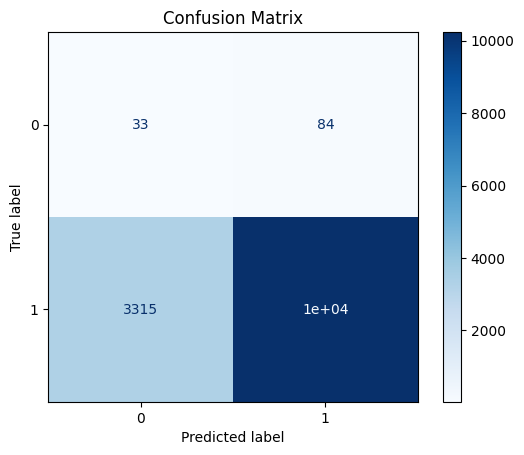

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [15]:
print(cm)

[[   33    84]
 [ 3315 10237]]


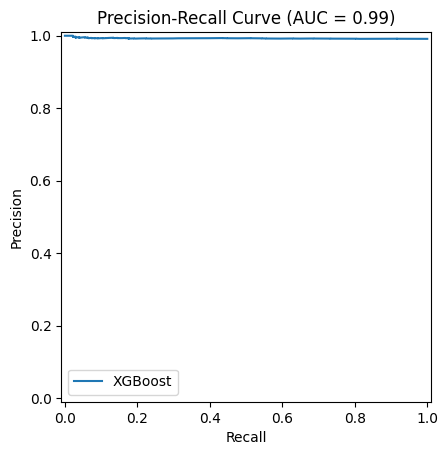

In [16]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc
# Compute precision, recall, and thresholds
# precision, recall, _ = precision_recall_curve(y_test, y_scores)
# pr_auc = auc(recall, precision)

# Plot the Precision-Recall curve
disp = PrecisionRecallDisplay(precision=precision_curve, recall=recall_curve, estimator_name="XGBoost")
disp.plot()
plt.title(f"Precision-Recall Curve (AUC = {pr_auc:.2f})")
plt.show()

In [17]:
# Display feature importance
importance = pd.Series(model.feature_importances_, index=FEATURES).sort_values(ascending=False)
print("\n--- Top Feature Importances ---")
print(importance)


--- Top Feature Importances ---
num_orders                  0.251420
distinct_payment_types      0.090828
pct_on_time                 0.090711
days_since_last_purchase    0.083564
ltv_180d                    0.077656
avg_order_value             0.073880
lifetime_value              0.071959
avg_basket_size             0.070971
avg_review_score            0.061903
pct_negative_reviews        0.057420
distinct_categories         0.053867
num_orders_180d             0.015821
num_canceled_orders         0.000000
dtype: float32


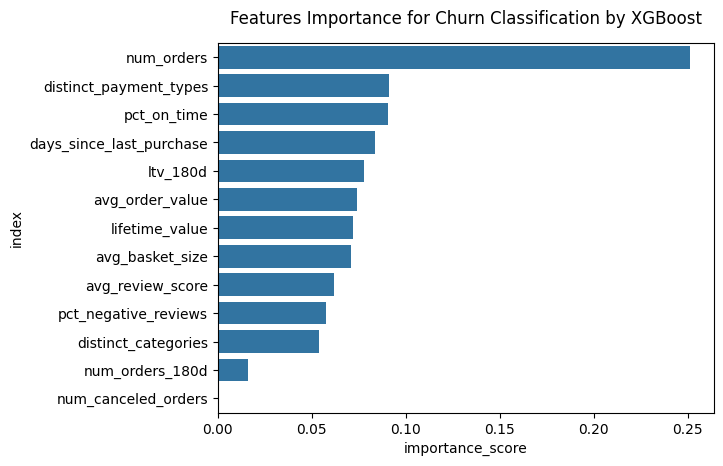

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
df_im = importance.rename("importance_score").reset_index()
sns.barplot(data=df_im, y="index", x="importance_score")
plt.title("Features Importance for Churn Classification by XGBoost", y=1.03)
plt.show()

In [109]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

# 1. Use the correct, large ratio for un-biasing
R_xgboost_correct = model.get_params().get('scale_pos_weight') # Use the value you calculated in Step 1

# 2. Get the raw (biased) probabilities
y_prob_biased = model.predict_proba(X_test)[:, 1]

# 3. Apply the calibration
y_prob_calibrated = y_prob_biased / (y_prob_biased + (1 - y_prob_biased) / R_xgboost_correct)

# 4. Check for leakage and evaluate performance
calibrated_roc_auc = roc_auc_score(y_test, y_prob_calibrated)
calibrated_pr_auc = average_precision_score(y_test, y_prob_calibrated) 

print(f"Mean Calibrated Probability: {np.mean(y_prob_calibrated):.4f} (Must be near 0.0072)")
print(f"Corrected Calibrated ROC AUC: {calibrated_roc_auc:.4f}")
print(f"Corrected Calibrated PR AUC: {calibrated_pr_auc:.4f}")

Mean Calibrated Probability: 0.0169 (Must be near 0.0072)
Corrected Calibrated ROC AUC: 0.5675
Corrected Calibrated PR AUC: 0.9932


## Model Comparison

In [147]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [152]:
model_dict = {
    "Logistic Regression": LogisticRegression(random_state= 6199),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=6199)
    "Adaptive Boosting": AdaBoostClassifier(random_state=6199),
    "Random Forest" : RandomForestClassifier(n_estimators= 100, max_depth=5, random_state=6199)
    # "XGBoost" : XGB
}